<center><h1>Slab stress</h1></center>

The task it to predict slab stress under load in two different points. Slab can have different shapes.

In [1]:
import os

from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras.layers import Conv2DTranspose
from keras.layers import Dropout
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from skimage import transform
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm


%matplotlib inline
np.random.seed(42)
tf.random.set_seed(42)

# Data

Each slap divided on 56*56 points and described by following files with features:
* М_нагр.csv - 2-D matrix with applyed load points.
* Р-В_1.csv and Р-В_2.csv - The output stress is affected by the size of the slab and the distance between the point of force application and the other points on the slab. For this purpose we use the distances from the load point to the other points.
* М_формы.csv - Matrix with slab form: 1 - corresponds to slab, 0 - to empty space.
* М_напряж.csv - Target stress values.

In [2]:
DATA_PATH = 'data'
TRAIN_PATH = 'train'
TEST_PATH = 'test'
FILE_NAMES = (
    'М_нагр.csv',
    'Р-В_1.csv',
    'Р-В_2.csv',
    'М_формы.csv',
    'М_напряж.csv',
)
IMAGE_SHAPE = (64, 64)

In [3]:
def load_dataset(path, file_list=None, verbose=False):
    """
    Load data from directory.

    Samples must be diveded on separate sub-directories and
    have the same number of features.

    Parameters
    ----------
    path : str
        Directory path.
    file_list : iterable, optional
        File names in sub-directories. If None, than will read all files.
    verbose : bool
        If True, than will output the reading file names.

    Returns
    -------
    ndarray
        Ndarray with shape (n, width, height, features).
    """
    dir_list = os.listdir(path)
    data = []
    # go thro samples
    for directory in tqdm(dir_list, 'Loading dataset'):
        if file_list is None:
            file_list = os.listdir(os.path.join(path, directory))
        data_batch = []
        # go thro features
        for file_name in file_list:
            if verbose:
                print(os.path.join(path, directory, file_name))
            data_batch.append(
                np.loadtxt(os.path.join(path, directory, file_name), delimiter=';')
            )
        data.append(data_batch)
        if verbose:
            print('---------------')
    return np.array(data, order='F').transpose((0, 2, 3, 1))

In [4]:
def resize_images(images, dim, **kwargs):
    """
    Resize all images in the given array.

    Use `skimage.transform.resize` for transformation and accept corresponding parameters in kwargs.

    Parameters
    ----------
    images : array_like
        Arra with data.
    dim : typle(int)
        Target size.

    Returns
    -------
    ndarray 
    """
    result = []
    for i in range(len(images)):
        result.append(transform.resize(images[i], dim, **kwargs))
    return np.array(result)

In [5]:
class Scaler2d():
    """
    Custom normalizator for 4-D arrays.
    """

    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, data):
        self.mean = data.mean(axis=(0, 1, 2))
        self.std = data.std(axis=(0, 1, 2))

    def transform(self, data):
        return (data - self.mean) / self.std

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

    def inverse_transform(self, data):
        return data * self.std + self.mean

In [6]:
data = load_dataset(DATA_PATH, FILE_NAMES)

Loading dataset: 100%|██████████| 11/11 [00:00<00:00, 31.69it/s]


In [7]:
data.shape

(11, 56, 56, 5)

Data sample visualization

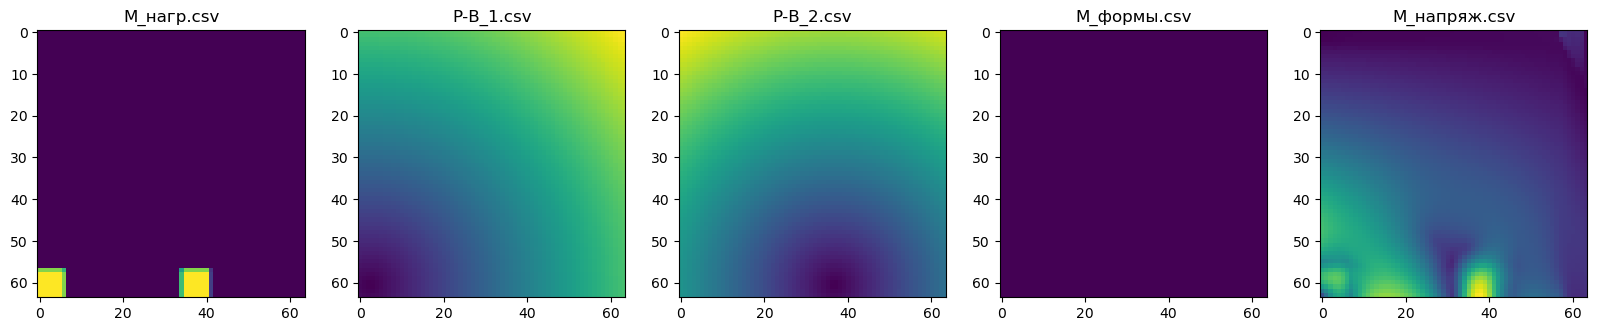

In [28]:
_, axs = plt.subplots(1, 5, figsize=(20, 8))
for i in range(5):
    axs[i].imshow(data[0, :, :, i])
    axs[i].set_title(FILE_NAMES[i]);

We need to increace size, because Pix-to-pix architecture requere image size of power 2.

In [8]:
data = resize_images(data, IMAGE_SHAPE)
data.shape

(11, 64, 64, 5)

Normilize data exept shape arrays. We don't need to normalize shape arrays because they are binary.

In [9]:
scaler_x = Scaler2d()
# exclude shape array
x_scaled = scaler_x.fit_transform(data[:, :, :, :-2])
# add shape array
x_scaled = np.concatenate((x_scaled, data[:, :, :, -2, np.newaxis]), 3)

scaler_y = Scaler2d()
y_scaled = scaler_y.fit_transform(data[:, :, :, -1])
y_scaled = y_scaled[..., np.newaxis]

In [ ]:
np.save(os.path.join(TRAIN_PATH, 'train16_x_scaled'), x_scaled, fix_imports=False)

In [ ]:
np.save(os.path.join(TRAIN_PATH, 'train16_y_scaled'), y_scaled, fix_imports=False)

In [ ]:
data = np.load(os.path.join(TRAIN_PATH, 'train16.npy'), fix_imports=False)

# Utility

In [10]:
def plot_loss(hist):
    """
    Plot model training and validation losses.
    """
    loss = hist['loss']
    val_loss = hist['val_loss']
    plt.plot(loss, "--", linewidth=3, label="train")
    plt.plot(val_loss, linewidth=3, label="val")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()

In [11]:
def compare_predictions(predictions, target, cmap=None):
    """
    Show pairs of predicted and target images.

    Parameters
    ----------
    predictions : array_like
        Array with predicted images.
    target : array_like
        Array with target images.
    """
    # compute max scale value
    vmax = max(predictions.max(), target.max())
    count = predictions.shape[0]
    _, axs = plt.subplots(count, 2, figsize=(13, 5*count))
    for i, ax in zip(range(len(predictions)), axs):
        sns.heatmap(predictions[i, :, :, 0], cmap=cmap, ax=ax[0], vmin=0, vmax=vmax)
        sns.heatmap(target[i, :, :, 0], cmap=cmap, ax=ax[1], vmin=0, vmax=vmax);

# Model

The available features are similar to an image with multiple channels and the output value is an image with one channel. That task looks like image transformation and to use pix-to-pix architecture looks like a good solution. Pix-to-pix architecture consist of two blocks - encoder and decoder with connections between them. The main difference is that we an have additional parameters vector for image-like data. There are two possible places where to concatenate data - before and after decoder.

In [12]:
def encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [13]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    g = Activation('relu')(g)
    return g

In [14]:
def define_model(image_shape):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)
    # encoder model
    e1 = encoder_block(in_image, 64, batchnorm=False)
    e2 = encoder_block(e1, 128)
    e3 = encoder_block(e2, 256)
    e4 = encoder_block(e3, 512)
    e5 = encoder_block(e4, 512)
    b = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e5)
    b = Activation('relu')(b)
    # decoder model
    d1 = decoder_block(b, e5, 512)
    d2 = decoder_block(d1, e4, 512, dropout=False)
    d3 = decoder_block(d2, e3, 256, dropout=True)
    d4 = decoder_block(d3, e2, 128, dropout=True)
    d5 = decoder_block(d4, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(1, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d5)
    out_image = Activation('tanh')(g)

    model = Model(in_image, outputs=out_image)
    return model

In [16]:
model = define_model(x_scaled.shape[1:])

c:\Users\kostr\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


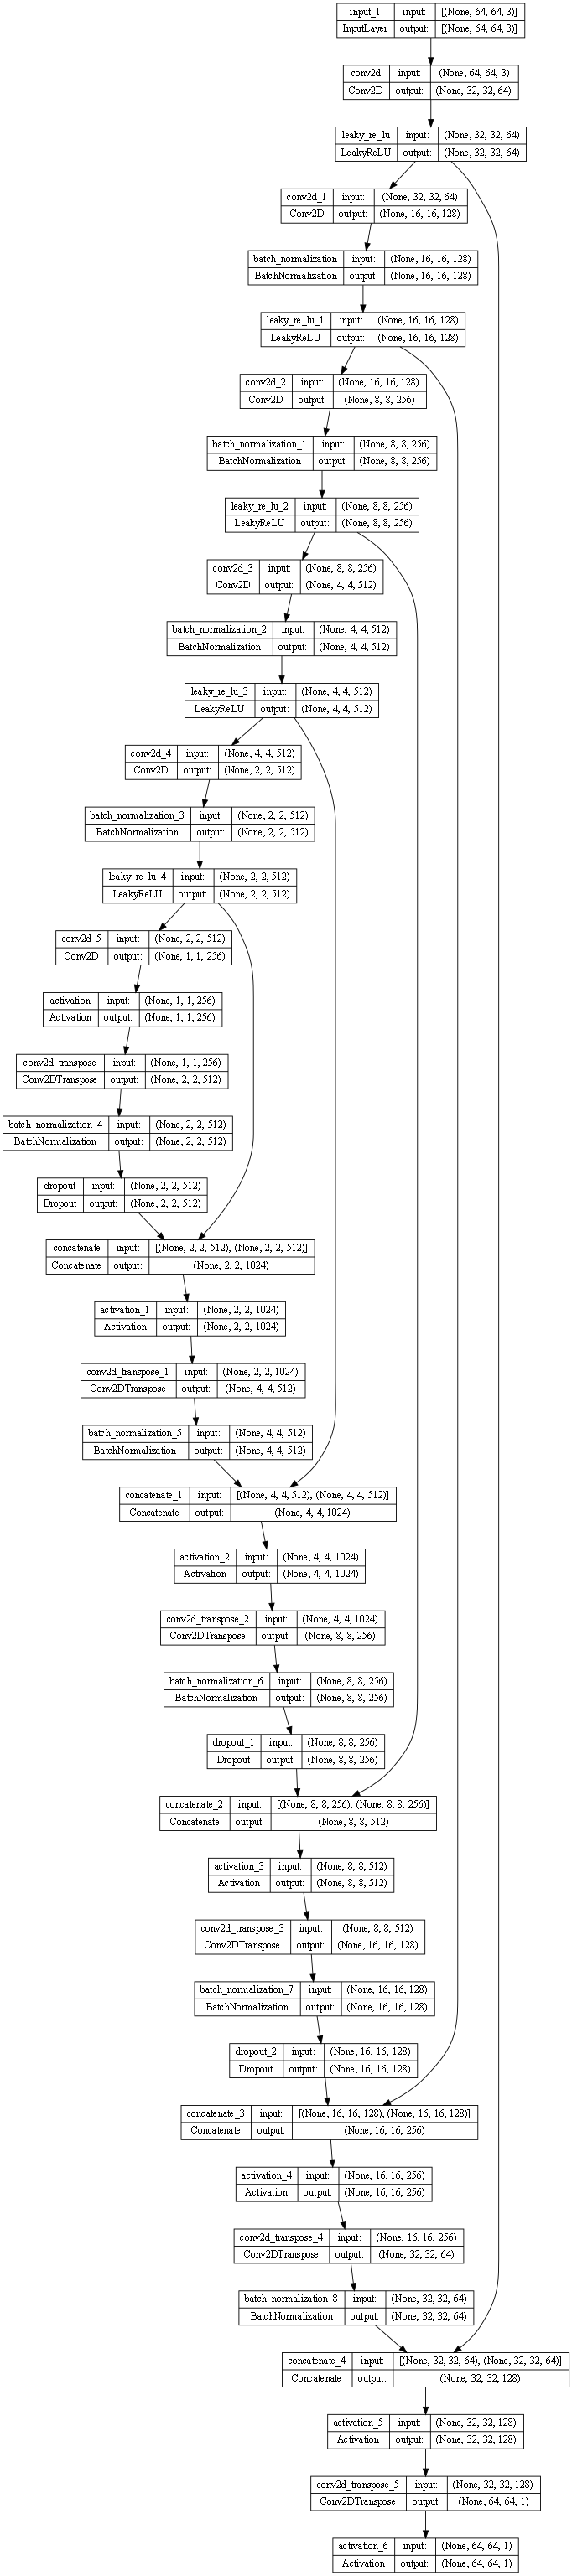

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [18]:
model.compile('adam', 'mean_absolute_error')

Rigth now we don't have a lot of data, so there are no reasons to divide data into train and validation sets or to set a lot of epochs.

In [90]:
history = model.fit(x_scaled, y_scaled, epochs=10)

Epoch 1/10
1/1 [==============================] - 9s 9s/step - loss: 0.7358
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 0.6091
Epoch 3/10
1/1 [==============================] - 4s 4s/step - loss: 0.5158
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 0.4564
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 0.4169
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 0.3895
Epoch 7/10
1/1 [==============================] - 4s 4s/step - loss: 0.3662
Epoch 8/10
1/1 [==============================] - 3s 3s/step - loss: 0.3507
Epoch 9/10
1/1 [==============================] - 3s 3s/step - loss: 0.3371
Epoch 10/10
1/1 [==============================] - 3s 3s/step - loss: 0.3213


Despite the fact that we can't precisely evaluate model, we still can see that loss is decresing. That mean that the chosen architecture suitable for out task.

In [ ]:
model.save('model')

In [ ]:
model = keras.models.load_model('model')

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [93]:
predicted = model.predict(x_scaled[3:5])

1/1 [==============================] - 1s 605ms/step


In [94]:
predicted = scaler_y.inverse_transform(predicted)
predicted.shape

(2, 64, 64, 1)

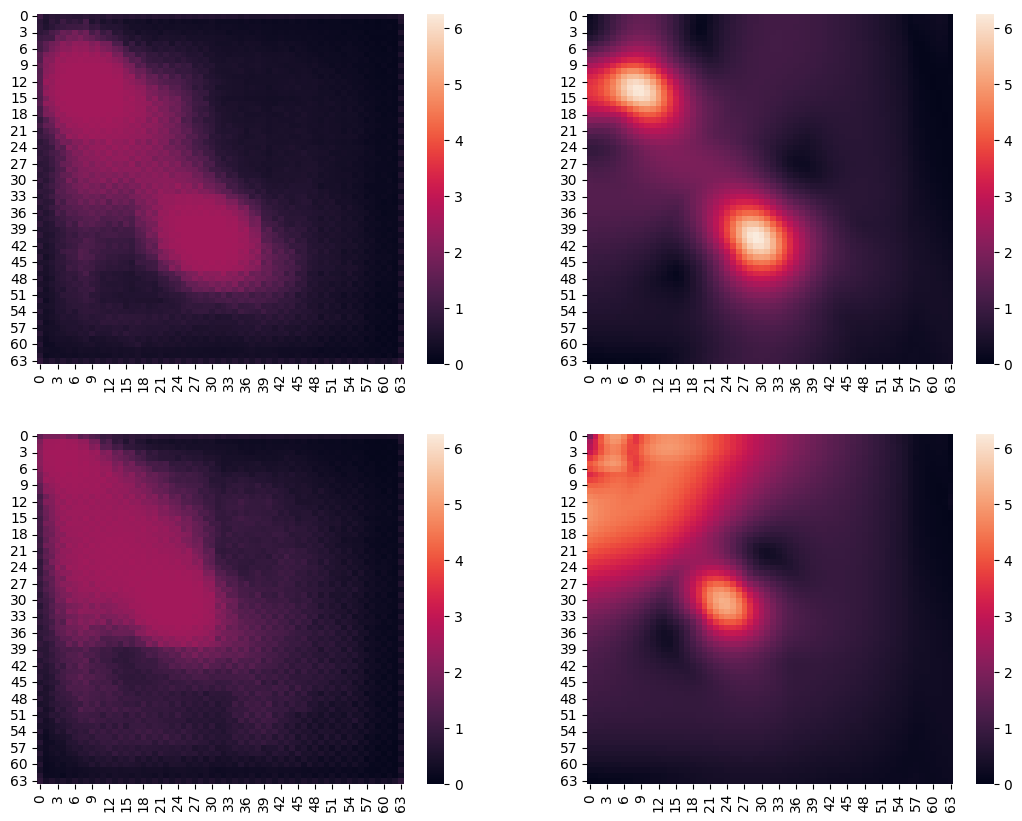

In [104]:
compare_predictions(predicted, data[3:5, :, :, -1, np.newaxis])